# Full sample motion profile and loss in degrees of freedom

In [1]:
import warnings

warnings.filterwarnings('ignore')
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fmriprep_denoise.visualization import figures, tables, utils
from myst_nb import glue


path_root = utils.get_data_root()

strategy_order = list(utils.GRID_LOCATION.values())
group_order = {'ds000228': ['adult', 'child'], 'ds000030':['control', 'ADHD', 'bipolar', 'schizophrenia']}

## Level of motion in samples quantified by mean framewise displacement

In [2]:
from statsmodels.stats.weightstats import ttest_ind

for_plotting = {}

datasets = ['ds000228', 'ds000030']
baseline_groups = ['adult', 'control']
for dataset, baseline_group in zip(datasets, baseline_groups):
    _, data, groups = tables.get_descriptive_data(dataset, path_root)
    baseline = data[data['groups'] == baseline_group]
    for group in group_order[dataset]:
        compare = data[data['groups'] == group]
        glue(
            f'{dataset}_{group}_mean',
            compare['mean_framewise_displacement'].mean(),
        )
        glue(
            f'{dataset}_{group}_sd',
            compare['mean_framewise_displacement'].std(),
        )
        glue(
            f'{dataset}_{group}_n',
            compare.shape[0],
        )
        if group != baseline_group:
            t_stats, pval, df = ttest_ind(
                baseline['mean_framewise_displacement'],
                compare['mean_framewise_displacement'],
                usevar='unequal',
            )
            glue(f'{dataset}_t_{group}', t_stats)
            glue(f'{dataset}_p_{group}', pval)
            glue(f'{dataset}_df_{group}', df)
    for_plotting.update({dataset: data})

0.1881064928771293

0.09326558238655397

33

0.3726003847486127

0.28907597426004483

122

-5.9903509055012885

1.5099409407527793e-08

148.7509307996301

0.16539396277836882

0.13728009970205265

106

0.13593892525398768

0.07369320920150656

35

1.6142391760943855

0.10934439067687333

109.8534368991607

0.18701416426998788

0.11641072751651341

41

-0.9589448521743521

0.34029949800608195

85.21354291761574

0.21773189578184338

0.10865071777683155

30

-2.189718164596873

0.03259039280825782

57.86321439589898

We will firstly characterise motion through the mean framewise displacement of each sample and the sub-groups in {numref}`fig:meanFD-original`.
This report will serve as a reference point for understanding the remainder of the results.
In `ds000228`, there was a significant difference in motion during the scan captured by mean framewise displacement 
between the child 
(M = {glue:text}`ds000228_child_mean:.2f`, SD = {glue:text}`ds000228_child_sd:.2f`, n = {glue:text}`ds000228_child_n:i`)
and adult sample
(M = {glue:text}`ds000228_adult_mean:.2f`, SD = {glue:text}`ds000228_adult_sd:.2f`, n = {glue:text}`ds000228_adult_n:i`;
t({glue:text}`ds000228_df_child:.2f`) = {glue:text}`ds000228_t_child:.2f`, p = {glue:text}`ds000228_p_child:.3f`).
This is consistent with the existing literature.
In `ds000030`, the only patient group shows a difference compared to the
control 
(M = {glue:text}`ds000030_control_mean:.2f`, SD = {glue:text}`ds000030_control_sd:.2f`, n = {glue:text}`ds000030_control_n:i`)
is the schizophrenia group 
(M = {glue:text}`ds000030_schizophrenia_mean:.2f`, SD = {glue:text}`ds000030_schizophrenia_sd:.2f`, n = {glue:text}`ds000030_schizophrenia_n:i`;
t({glue:text}`ds000030_df_schizophrenia:.2f`) = {glue:text}`ds000030_t_schizophrenia:.2f`, p = {glue:text}`ds000030_p_schizophrenia:.3f`).
There was no difference between the control and ADHD group
(M = {glue:text}`ds000030_ADHD_mean:.2f`, SD = {glue:text}`ds000030_ADHD_sd:.2f`, n = {glue:text}`ds000030_ADHD_n:i`;
t({glue:text}`ds000030_df_ADHD:.2f`) = {glue:text}`ds000030_t_ADHD:.2f`, p = {glue:text}`ds000030_p_ADHD:.3f`),
or the bipolar group 
(M = {glue:text}`ds000030_bipolar_mean:.2f`, SD = {glue:text}`ds000030_bipolar_sd:.2f`, n = {glue:text}`ds000030_bipolar_n:i`;
t({glue:text}`ds000030_df_bipolar:.2f`) = {glue:text}`ds000030_t_bipolar:.2f`, p = {glue:text}`ds000030_p_bipolar:.3f`).
In conclusion, adult samples have lower mean framewise displacement than youth samples.

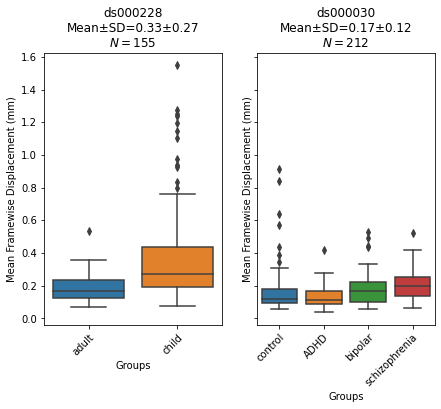

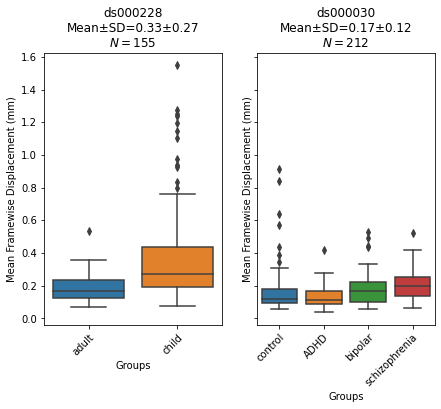

In [3]:
fig = plt.figure(figsize=(7, 5))
axs = fig.subplots(1, 2, sharey=True)
for dataset, ax in zip(for_plotting, axs):
    df = for_plotting[dataset]
    mean_fd = df['mean_framewise_displacement'].mean()
    sd_fd = df['mean_framewise_displacement'].std()
    df = df.rename(
        columns={
            'mean_framewise_displacement': 'Mean Framewise Displacement (mm)',
            'groups': 'Groups'
        }
    )
    sns.boxplot(
        y='Mean Framewise Displacement (mm)', x='Groups', data=df, ax=ax,
        order=group_order[dataset]
    )
    ax.set_xticklabels(group_order[dataset], rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(
        f'{dataset}\nMean\u00B1SD={mean_fd:.2f}\u00B1{sd_fd:.2f}\n$N={df.shape[0]}$'
    )
# fig.suptitle("Mean framewise displacement per sub-sample")

glue('meanFD-original', fig, display=False)

```{glue:figure} meanFD-original
:name: "fig:meanFD-original"

Mean framewise displacement of each dataset.

We found young subjects have higher motion compared to adults,
which is consistent with the pattern described in the literature.
Amongst psychiatric conditions, only the schizophrenia group shows a difference from the control group.
```

## The loss in temporal degrees of freedom in different strategies

The common analysis and denoising methods are based on linear regression.
Using more nuisance regressors can capture additional sources of noise-related variance in the data and thus improve denoising.
However, this comes at the expense of a loss of temporal degrees of freedom for statistical inference in further analysis.
This is an important point to consider alongside the denoising performance.

The average loss in temporal degrees of freedom by regressor number is summarised in {numref}`fig:dof-fig`.
In fMRIPrep, high-pass filtering is done through discrete cosine-basis regressors, 
labeled as `cosine_*` in fMRIPrep confounds output.
In the following section, the number of discrete cosine-basis regressors will be denoted as $c$. 
Depending on the length of the scan, the number of discrete cosine-basis regressors can differ ($c_{ds000228}=4$, $c_{ds000030}=3$). 
The `simple` and `scrubbing`-based strategies are the strategy with a fixed number of degrees of freedom loss.
`compcor` and `aroma`-based strategies show variability depending on the number of noise components detected.
In theory, `compcor6` should also report a fixed number of degrees of freedom loss.
However, fMRIPrep outputs the compcor components based on the 50% variance cut-off.
For some subjects the number of components could be lower than 6, hence the variability.

In {cite:t}`ciric_benchmarking_2017`, the equivalent `aroma` and `aroma+gsr` strategies were reported with 
a lower magnitude of loss in temporal degrees of freedom than `scrubbing` or `simple` strategies.
However, we did not observe this advantage is limited to samples with relatively low motion (i.e. adults).
When selecting a denoising strategy, 
The two datasets used in the current benchmark both contained subjects with behaviours deviating from the healthy controls.
`ds000228` consists of adult healthy controls and children.
`ds000030` includes healthy controls and subjects with three different psychiatric conditions.
the loss in degrees of freedom `simple` ($26 + c$) and `simple+gsr` ($27 + c$) used the least amount of regressors in the general population.
Certain sub-sample uses fewer regressors with the `aroma` and `aroma+gsr` strategies.
The reason potentially lies in the implementation of ICA-AROMA. 
ICA-AROMA uses a pre-trained model on healthy subjects to select noise components {cite:p}`aroma`.

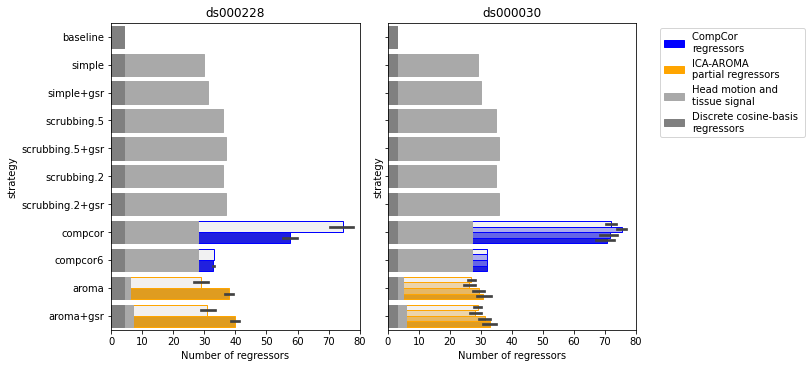

['adult', 'child']

['control', 'ADHD', 'bipolar', 'schizophrenia']

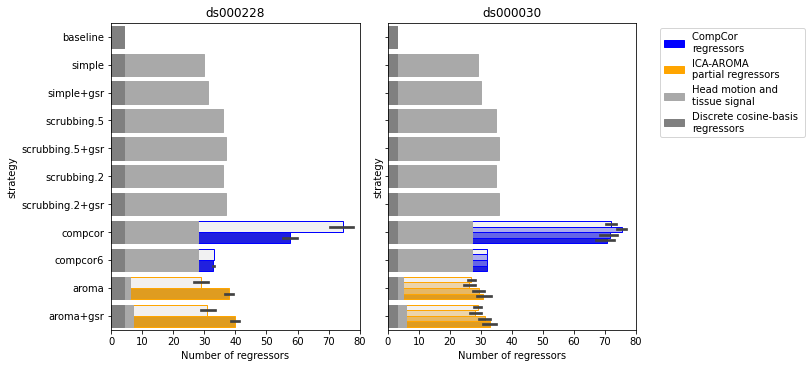

In [4]:
fig, ds_groups = figures.plot_dof_dataset(path_root)
glue(f'dof-fig', fig, display=False)
for ds, group in ds_groups:
    glue(f'group-order_{ds}', group, display=False)

```{glue:figure} dof-fig
:name: "fig:dof-fig"

Loss in temporal degrees of freedom breaks down into groups.

`compcor` and `aroma`-based strategies show variability depending on the number of noise components detected.
The variability is broken down into groups.
From the lightest hue to the darkest, the order of the group in `ds000228` is:
{glue:}`group-order_ds000228`.
From the lightest hue to the darkest, the order of the group in `ds000030` is:
{glue:}`group-order_ds000030`.
```

To compare the loss in the number of volumes from the scrubbing base strategy across datasets,
we calculate the proportion of volume loss to the number of volumes in a full scan ({numref}`fig:scrubbing-fig`).
`ds000228` includes child subjects and shows a higher loss in volumes compared to `ds000030` with adult subjects only.
This is consistent with the trend in the difference in mean framewise displacement,
and it fits the observation shown in literature {cite:p}`satterthwaite_impact_2012`.
In `ds000030`, we see a similar trend mirroring the mean framewise displacement results.
The schizophrenia group shows the highest amount of volumes scrubbed,
followed by the bipolar group, and comparable results between the control group and ADHD group.
With a stringent 0.2 mm threshold, groups with high motion will lose on average close to half of the volumes.

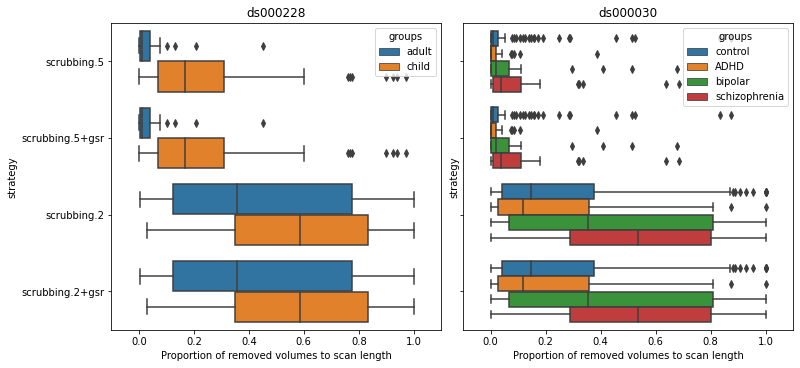

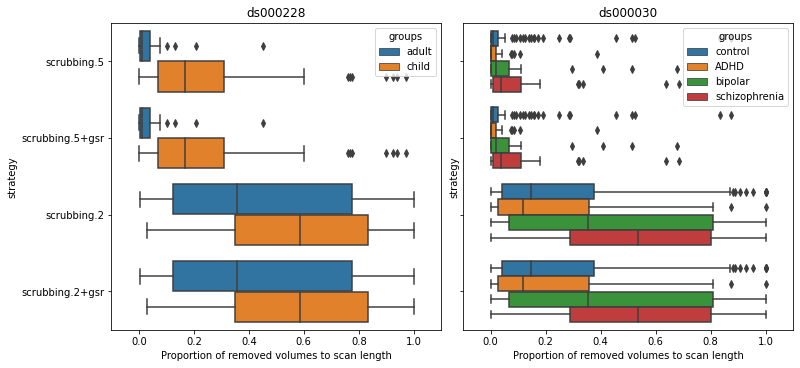

In [5]:
fig = figures.plot_vol_scrubbed_dataset(path_root)
glue(f'scrubbing-fig', fig, display=False)

```{glue:figure} scrubbing-fig
:name: "fig:scrubbing-fig"

Loss in the number of volumes in proportion to the full length of the scan.

Broken down the loss of volumes by groups in each dataset, we can see the trend is similar to the mean framewise displacement result. 
```